<a href="https://colab.research.google.com/github/carterc64/CS-472-Intro-to-AI/blob/main/HW3CarterCopen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
import sys
assert sys.version_info >= (3,7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Loads in the housing data for later use

In [185]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def loadHousingData():
    tarballPath = Path("datasets/housing.tgz")
    if not tarballPath.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarballPath)
        with tarfile.open(tarballPath) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = loadHousingData()

.head() shows the first five rows of data, here each row represents a district and its attributes

In [186]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


.info() shows general info of the dataset, number of rows, attributes, and non-null values, will have to adjust total_bedrooms later as it doesn't have enough values

In [187]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Expands the categorical attribute to show what categories are possible

In [188]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

.describe() shows a summary of all numerical attributes in the data set

In [189]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


.hist() shows a histogram for a numerical attribute giving a easier to see view of value distribution

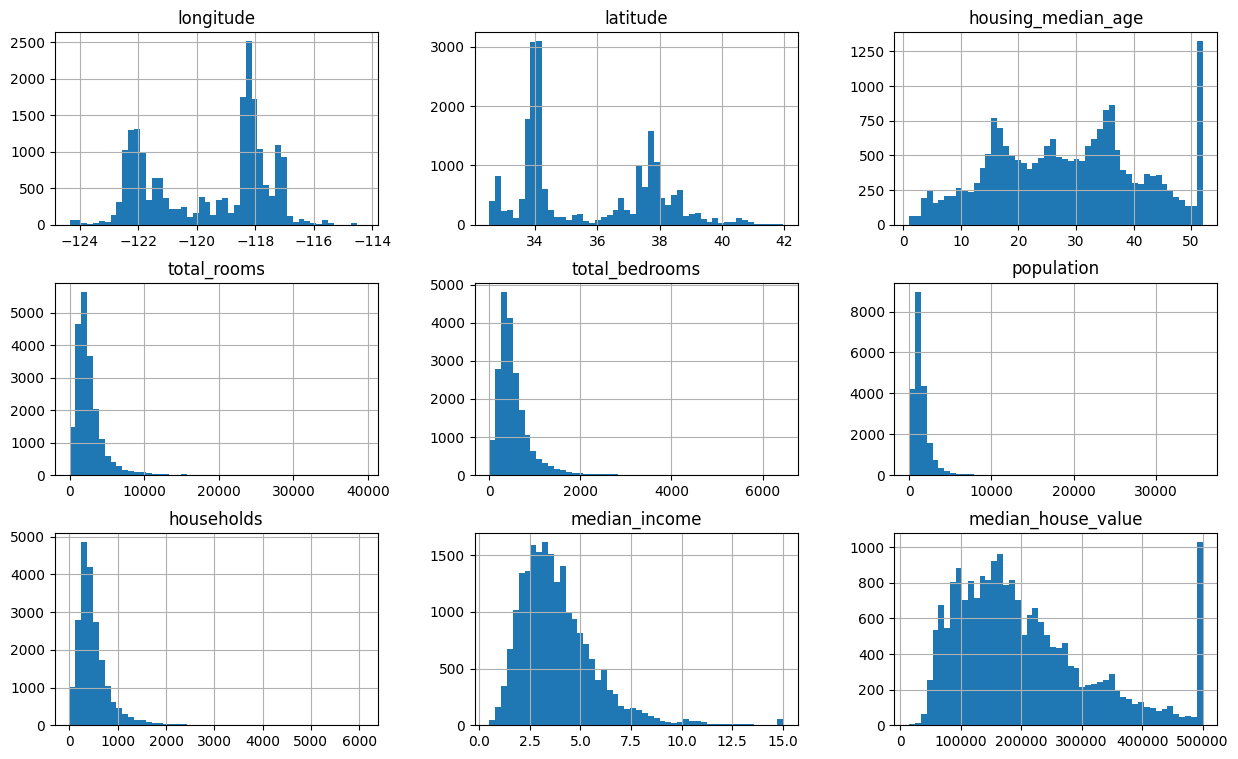

In [190]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(15,9))
plt.show()

<Axes: >

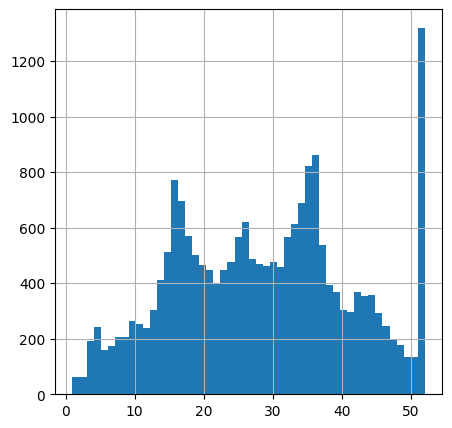

In [191]:
housing.housing_median_age.hist(bins=50, figsize=(5,5))

We are now trying to create a test set to use for later, however this function will create a diffrent random test set each time so we need a better method. Even adding a random seed will still create a diffrent set once the dataset is updated.

In [192]:
import numpy as np

def shuffleAndSplitData(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [193]:
train_set, test_set = shuffleAndSplitData(housing, 0.2)
len(train_set)


16512

In [194]:
len(test_set)

4128

Since the data set isnt very big random test samples aren't as effective here we split the data using a category attribute to avoid sampling bias. To do this we use the median_income attribute. We also show the splits in a histogram for viewing.

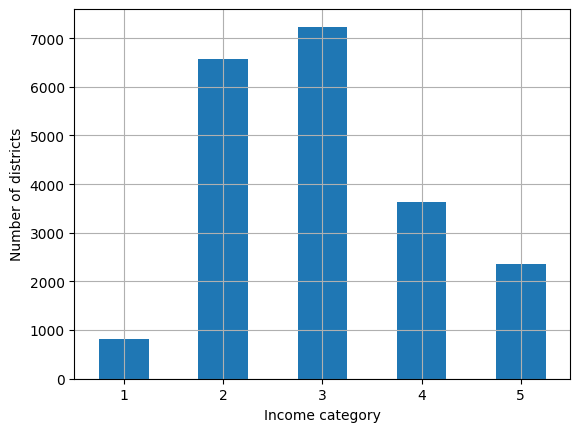

In [195]:
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1,2,3,4,5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

We can now perform stratified sampling based off of our newly made income category using train_test_split(). We then look at the income category proportions of this set

In [196]:
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

Removes the income_cat from data as we dont use past generating a stratified test set

In [197]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis = 1, inplace = True)

We need a copy of the training set in order to explore through the data, however we dont want to change the orginal set, hence why we used a copy

In [198]:
housing = strat_train_set.copy()

Used to plot and visualize the location data in are copy of the train set

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


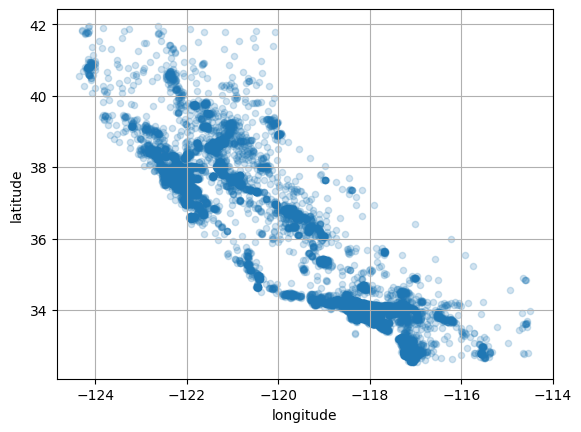

In [199]:
housing.plot(kind="scatter", x= "longitude", y = "latitude", grid = True, alpha=0.2)
plt.show()

Now we look at the distribution of the prices and notice location corelates heavily and the highest prices seem to be in clusters

<Axes: xlabel='longitude', ylabel='latitude'>

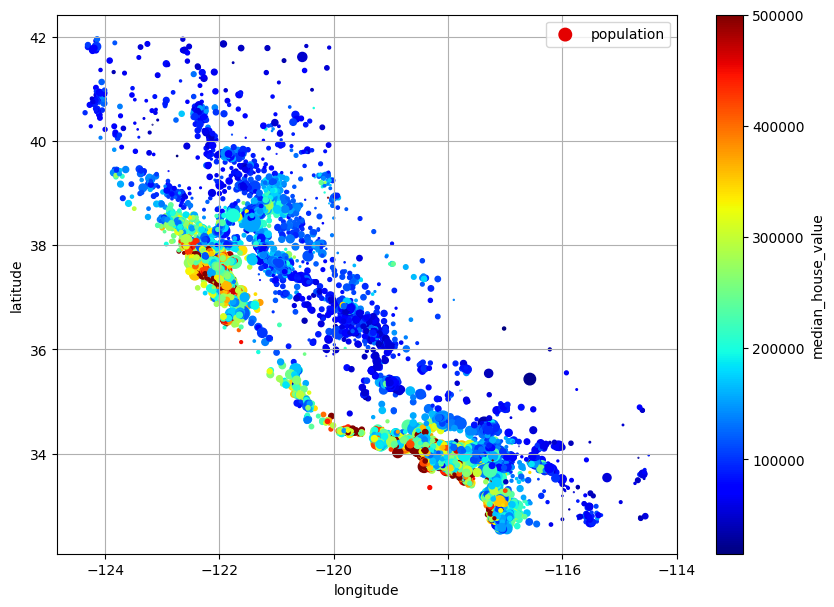

In [200]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, 
             s = housing["population"] / 100, label = "population", c = "median_house_value", cmap = "jet", 
             colorbar = True, legend = True, sharex = False, figsize = (10,7))

.corr() allows you to compute the standard correlation coefficent between every attribute alowing us to see what has the most influence on the median_house_value attribute. We see median_income has the highest positive correlation to the median_house_value while the more latitude you have grants a negative corelation. 

In [201]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Here we graph the correlation between income and houe_value and notice lines at the 500,000 cutoff, around 450,000 and 350,000. We may need to alter the data so these lines are present in our model.

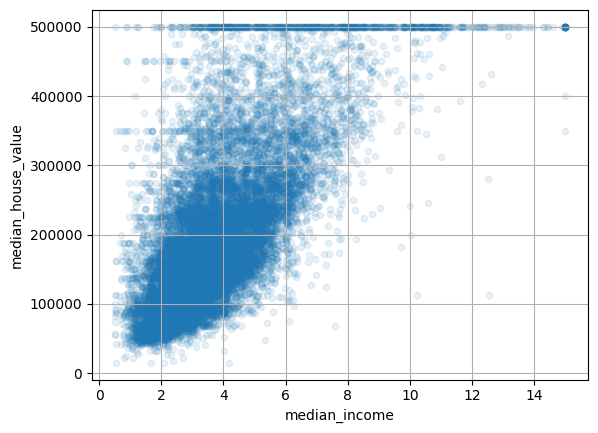

In [202]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1, grid=True)
plt.show()

Next we look further into the data trying to identify correlations between attribures, we add 3 attributes to find ratio of bedrooms in a house more corelated to the price than than just the number of rooms. 

In [203]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [204]:
corr_matrix["median_income"].sort_values(ascending = True)

bedrooms_ratio       -0.619958
housing_median_age   -0.127043
latitude             -0.078137
longitude            -0.016542
people_per_house     -0.006662
total_bedrooms       -0.006038
population            0.004282
households            0.013637
total_rooms           0.197720
rooms_per_house       0.314316
median_house_value    0.688380
median_income         1.000000
Name: median_income, dtype: float64

In [205]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

Now our data needs to be clean for later use. The first issue was the null values we saw in the total_bedrooms atribute, we will use the SimpleImputer to insert the median value for these null entries. 

In [206]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")

housing_num = housing.select_dtypes(include = [np.number])
imputer.fit(housing_num)

imputer.statistics_


array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [207]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [208]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

We dealt with the numerical attributes using the imputer however the text attributes must be dealt with another way, here we begin looking into them. 

In [209]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


We now want to convert these text categories into numbered categories for easier use later on using an Encoder.

In [210]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:7]
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [211]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

The privous encoders categories leave a bias as farther apart values will be compared diffrentlty than close values. Even though 1H Ocean and Near Ocean shouch be consider similar, the encoder leaves the values far apart at 0,4. To fix this we will use binary attributes per category that way they are either 0 or 1.

In [212]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output = False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot



array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [213]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [214]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [215]:
df_test_unkown = pd.DataFrame({"ocean_proximity": ["NOWHERE", "ISLAND"]})

cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unkown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [216]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [217]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [218]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unkown), columns = cat_encoder.get_feature_names_out(), index = df_test_unkown.index)

Next we need to scale our data features so one feature isn't valued more than the other even though the numbers are smaller. Such as number of rooms and median income ranges. There are multiple ways to achieve this is normalization.

In [219]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

The next is standariztion, it is less affected by outliers in the data due to the method having no range restriction

In [220]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

Currently our input features have "heavy tails" with most data loaded onto one side of the graph. Before we scale we need to get rid of these tails and transform them to more closly resemble a favorable distribution. This way when we scale we wont squash alot of the values into a small range. 

In [221]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma = 0.1)

With the input features done we now look at the target values and make sure we can transform their heavy tails into more usable distributions as well. This can be done by using the TransformedTargetRegressor. It will scale the labels and train the model on those scaled labels.

In [223]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

some_new_data = housing[["median_income"]].iloc[:5] 

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

Adding a custom transformer for heavy-teailed distributions that replaces it with a logarithm version.

In [224]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func = np.exp)
log_pop = log_transformer.transform(housing[["population"]])
log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


Now we created a custom transformer that is trainable and allows it to learn parameters in the fit() method and use them in the transform() method.

In [227]:

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean = True):
    self.with_mean = with_mean

  def fit(self, X, y = None):
    X = check_array(X)
    self.mean_ = X.mean(axis = 0)
    self.scale_ = X.std(axis = 0)
    self.n_features_in_ = X.shape[1]
    return self

  def transform(self, X):
    check_is_fitted(self)
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X - self.mean_
    return X / self.scale_

Now we will create a new custom transformer and implement KMeans into fit() and rbf_kernel() into transform()

In [238]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters = 10, gamma = 1.0, random_state = None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y = None, sample_weight = None):
    self.kmeans_ = KMeans(self.n_clusters, random_state = self.random_state)
    self.kmeans_.fit(X, sample_weight = sample_weight)
    return self

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)

  def get_feature_names_out(self, names = None):
    return [f"Cluster {i} simulatity" for i in range(self.n_clusters)]

We now use the ClusterSimilarity class to find 10 clusters within the data. First calling fit_transform() to weight each district by house value. Uses kmeans to locate those clusters, then measures the similarity between those clusters. 

In [241]:
cluster_simil = ClusterSimilarity(n_clusters = 10, gamma = 1, random_state = 42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)

similarities[:3].round(2)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

We now need to create a pipeline to make sure the data recieves its transformations in the right order. We use the Pipeline class in order to do so.

In [250]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([("impute", SimpleImputer (strategy = "median")), ("standardize", StandardScaler())])

housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [251]:
num_pipeline[:-1]

Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])

In [252]:
num_pipeline[1]

StandardScaler()

We have been dealing with categorical and numerical attributes seperatly we will now create a transformer that will handle both at the same time. That way when we later transform the data we can do it all at once.

In [255]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"), OneHotEncoder(handle_unknown = "ignore"))

preprocessing = ColumnTransformer([("num", num_pipeline, num_attribs), ("cat", cat_pipeline, cat_attribs),])

housing_prepared = preprocessing.fit_transform(housing)

housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

We now comine all transormations to make a single pipeline that will do every data transformation with one call.

In [258]:
from sklearn.compose import make_column_selector

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  

def ratio_pipeline():
    return make_pipeline(SimpleImputer(strategy="median"), FunctionTransformer(column_ratio, feature_names_out = ratio_name),
                          StandardScaler())

log_pipeline = make_pipeline( SimpleImputer(strategy = "median"), FunctionTransformer(np.log, feature_names_out="one-to-one"),
                            StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters = 10, gamma = 1., random_state = 42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy = "median"), StandardScaler())


preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline) 

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16512, 24)

In [259]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 simulatity',
       'geo__Cluster 1 simulatity', 'geo__Cluster 2 simulatity',
       'geo__Cluster 3 simulatity', 'geo__Cluster 4 simulatity',
       'geo__Cluster 5 simulatity', 'geo__Cluster 6 simulatity',
       'geo__Cluster 7 simulatity', 'geo__Cluster 8 simulatity',
       'geo__Cluster 9 simulatity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

With the data now prepared we start using machine learning models starting with linear regression

In [261]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f2...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2dfbe65040>)])),
                ('linearregression', LinearRegression())])

In [262]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([243700., 372400., 128800.,  94400., 328300.])

In [263]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

Here we see the values are off by up to 200,000 using the linear regression model, we now use mean_sqaured_error function to get our prediction error. The prediction error we receive shows we are underfitting our data.

In [266]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)

lin_rmse

68687.89176590038

We now switch to a DecisionTreeRegressor to see try and see if the underfitting problem is being caused by a model that is too weak. 

In [267]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f2...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2dfbe65040>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [268]:
housing_predictions = tree_reg.predict(housing)

tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)
tree_rmse

0.0

Here we see an error of 0 which either means the model is perfect or overfitting. To see whats really happening we use the cross-validation feature that will split the training set into 10 folds for use of evaluation and training.

In [272]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring = "neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

This tells us the Tree model is slight better but has severe overfitting due to the training error is 0 and the validtion error is high. Due to this we try a new model the RandomForestRegressor.

In [274]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state = 42))

forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring = "neg_root_mean_squared_error", cv = 10)

pd.Series(forest_rmses).describe()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64

This shows RandomForestRegressor as a potential model for this dataset but still has some overfitting to overcome. 